In [3]:
"""
Fine-grained classification practice with Flower-17
"""

# Python Packages
import argparse
import os
import time
# 3rd Party Packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# User Packages
from start.preprocessing import ImageToTensorPreprocessor, ResizePreprocessor
from start.loader import ImageDataset
from start.model import MiniVGGNet


In [ ]:
# Load Flowers-17 dataset
dataset = ImageDataset(
    preprocessors=[
        ResizePreprocessor(224, 224, aspect_preserving=True),
        ImageToTensorPreprocessor()
    ]
)
"""
(data, labels) = dataset.load(
    dataset_path=r'/home/share/dataset/flowers17',
    verbosity=80
)
"""
(data, labels) = dataset.load(
    dataset_path=r'T:\temp\simeon\dataset\custom',
    verbosity=80
)

classes = set(labels)

print('data shape: {}'.format(data.shape))
print('labels shape: {}'.format(labels.shape))
print('classes: {}'.format(classes))


# Normalize data
data = data.astype(np.float) / 255.0

[INFO] Processing label: person
[INFO] processed 80 person images
[INFO] processed 160 person images
[INFO] processed 240 person images
[INFO] processed 320 person images
[INFO] processed 400 person images
[INFO] processed 480 person images
[INFO] processed 560 person images
[INFO] processed 560 person images
[INFO] processed 640 person images
[INFO] processed 720 person images
[INFO] processed 800 person images
[INFO] processed 880 person images
[INFO] processed 960 person images
[INFO] processed 1040 person images
[INFO] Processing label: soldier
[INFO] processed 80 soldier images
[INFO] processed 160 soldier images
[INFO] processed 240 soldier images
[INFO] processed 320 soldier images
[INFO] processed 400 soldier images
[INFO] processed 480 soldier images
[INFO] processed 560 soldier images
[INFO] processed 640 soldier images
[INFO] processed 720 soldier images
[INFO] processed 800 soldier images
[INFO] processed 880 soldier images
[INFO] processed 960 soldier images
[INFO] process

In [2]:
# Setup data splits
from sklearn.model_selection import StratifiedKFold

n_classes = len(classes)

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

# Partition into train and test splits
"""
(trainX, testX, trainY, testY) = train_test_split(
    data, labels,
    test_size=0.3,
    random_state=int(time.time()),
    stratify=list(labels)
)
(valX, testX, valY, testY) = train_test_split(
    testX, testY,
    test_size=0.4,
    random_state=int(time.time()),
    stratify=list(testY)
)
"""

# Binarize output to one hot vectors
if n_classes > 2:
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    valY = lb.fit_transform(valY)
    testY = lb.fit_transform(testY)
else:
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    valY = le.fit_transform(valY)
    testY = le.fit_transform(testY)

# Data augmentation
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def create_model(n_classes, alpha=1.4):
    # Initialize the optimizer and model
    print('[INFO] compiling model...')
    opt = SGD(lr=0.05)
    properties = {
        'width':    64,
        'height':   64,
        'channels': 3,
        'classes':  len(classes)
    }
    #model = MiniVGGNet.build(properties)
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    model = Sequential()
    model.add(MobileNetV2(
        input_shape=(224, 224, 3),
        alpha=alpha, 
        depth_multiplier=1, 
        include_top=False, 
        weights='imagenet', 
        input_tensor=None, 
        pooling='avg'
    ))
    
    if n_classes > 2:
        model.add(Dense(
            units=n_classes,
            activation='softmax',
            use_bias=True,
            kernel_initializer='glorot_uniform',
            bias_initializer='glorot_uniform',
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None
        ))
        model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    # Hot dog or not hot dog
    else:
        model.add(Dense(
            units=1,
            activation='sigmoid',
            use_bias=True,
            kernel_initializer='glorot_uniform',
            bias_initializer='glorot_uniform',
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None
        ))
        model.compile(
            loss='binary_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    return model

model = create_model(n_classes=2)

# Initialize TensorBoard
from tensorflow.keras.callbacks import TensorBoard

BATCH_SIZE = 32

timestamp = time.time()

tb_callback = TensorBoard(
    log_dir='./logs/{}'.format(timestamp), 
    histogram_freq=1, 
    batch_size=BATCH_SIZE, 
    write_graph=False, 
    write_grads=False, 
    write_images=False, 
    embeddings_freq=0,
    embeddings_layer_names=None, 
    embeddings_metadata=None, 
    embeddings_data=None
)


# Train the network
print('[INFO] training network...')
N_EPOCHS = 35
history = model.fit_generator(
    augmenter.flow(trainX, trainY, 
                   batch_size=BATCH_SIZE),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=[tb_callback],
    verbose=1
)

import pycm

# Evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=BATCH_SIZE)
if not n_classes > 2:
    threshold = 0.5
    predictions[predictions>threshold] = 1
    predictions[predictions<=threshold] = 0
    predictions = predictions.astype(np.int)

if n_classes > 2:
    cm = pycm.ConfusionMatrix(
        actual_vector=lb.inverse_transform(testY),
        predict_vector=lb.inverse_transform(predictions)
    )
else:
    cm = pycm.ConfusionMatrix(
        actual_vector=le.inverse_transform(testY),
        predict_vector=le.inverse_transform(predictions)
    )
cm.save_html(r'T:\temp\simeon\dataset\confusion_matrix')

# Plot the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N_EPOCHS), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, N_EPOCHS), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N_EPOCHS), history.history['acc'], label='train_acc')
plt.plot(np.arange(0, N_EPOCHS), history.history['val_acc'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.savefig(r'T:\temp\simeon\dataset\training.jpg')
plt.show()

NameError: name 'classes' is not defined

classes: {'soldier', 'person'}
testY shape: (262,)
predictions shape: (262, 1)
soldiers_classified_people shape: (27, 224, 224, 3)
7 x 4 plot


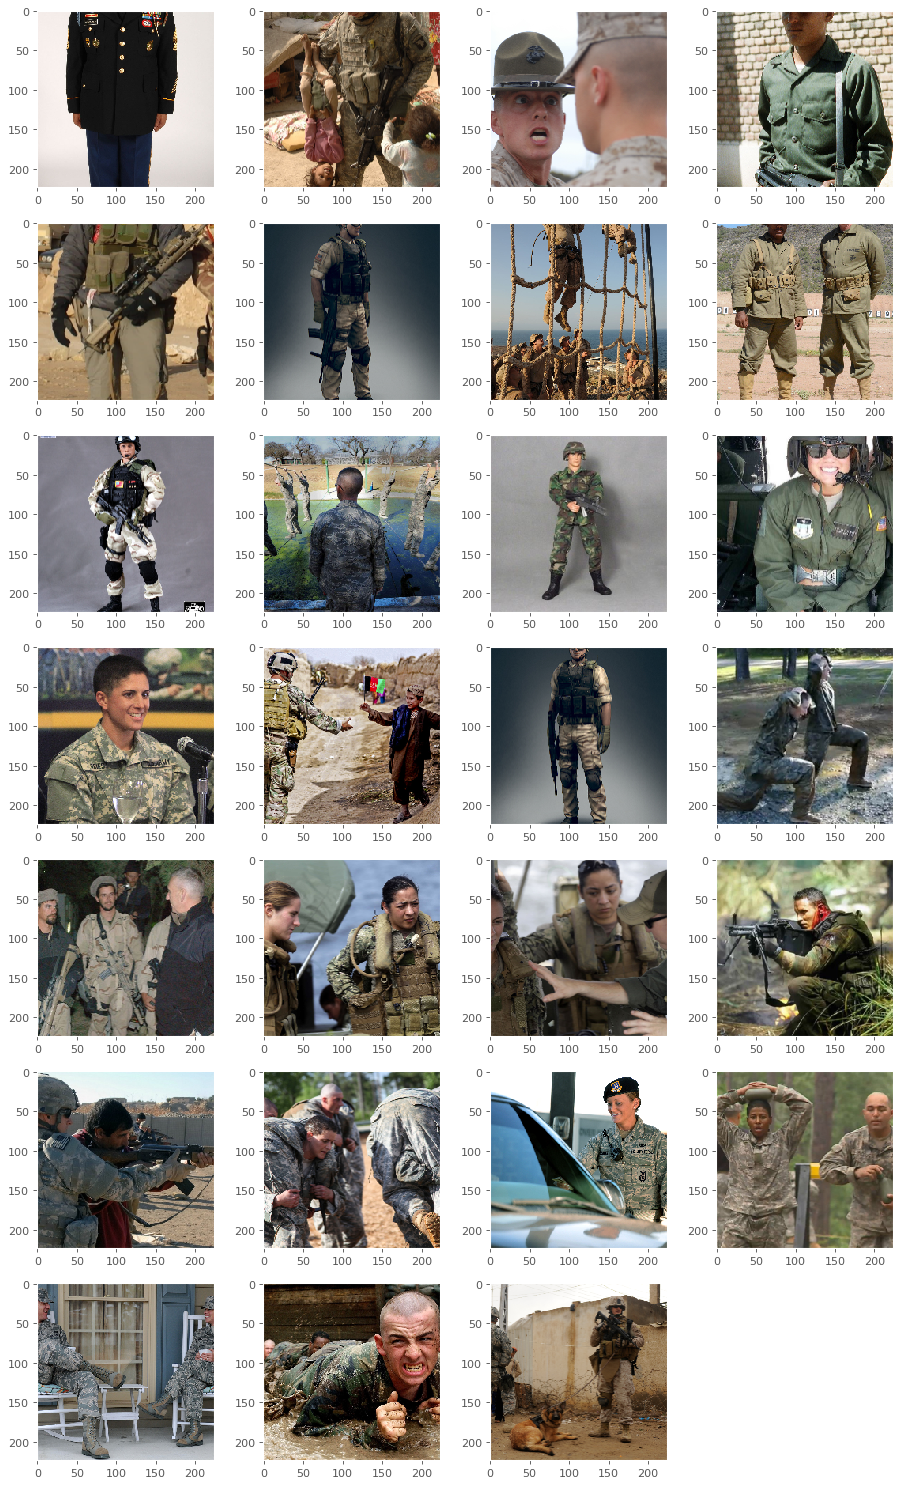

In [19]:
# Plot images that were soldiers classified as people
print('classes: {}'.format(classes))
print('testY shape: {}'.format(testY.shape))
print('predictions shape: {}'.format(predictions.shape))
soldiers_classified_people = testX[np.logical_and(testY == 1, np.squeeze(predictions) == 0)]
print('soldiers_classified_people shape: {}'.format(soldiers_classified_people.shape))
# Draw figure
if soldiers_classified_people.shape[0] > 0:
    IMAGES_PER_ROW = 4
    rows = (soldiers_classified_people.shape[0] // IMAGES_PER_ROW) + 1
    f = plt.figure(
        num=1, 
        figsize=(14, int(14*rows/float(IMAGES_PER_ROW))), 
        dpi=80, 
        facecolor='w', 
        edgecolor='k'
    )
    print('{} x {} plot'.format(rows, IMAGES_PER_ROW))
    for subidx in range(soldiers_classified_people.shape[0]):
        # subplot is 1-indexed
        plt.subplot(rows, IMAGES_PER_ROW, subidx+1)
        f.gca().grid(False)
        plt.imshow(soldiers_classified_people[subidx][..., ::-1])
    plt.show()

In [21]:
# Plot images that were soldiers classified as people
print('classes: {}'.format(classes))
print('testY shape: {}'.format(testY.shape))
print('predictions shape: {}'.format(predictions.shape))
people_classified_soldiers = testX[np.logical_and(testY == 0, np.squeeze(predictions) == 1)]
print('people_classified_soldiers shape: {}'.format(people_classified_soldiers.shape))
# Draw figure
if people_classified_soldiers.shape[0] > 0:
    IMAGES_PER_ROW = 4
    rows = (people_classified_soldiers.shape[0] // IMAGES_PER_ROW) + 1
    f = plt.figure(
        num=2, 
        figsize=(14, int(14*rows/float(IMAGES_PER_ROW))), 
        dpi=80, 
        facecolor='w', 
        edgecolor='k'
    )
    print('{} x {} plot'.format(rows, IMAGES_PER_ROW))
    for subidx in range(people_classified_soldiers.shape[0]):
        # subplot is 1-indexed
        plt.subplot(rows, IMAGES_PER_ROW, subidx+1)
        f.gca().grid(False)
        plt.imshow(people_classified_soldiers[subidx][..., ::-1])
    plt.show()

classes: {'soldier', 'person'}
testY shape: (262,)
predictions shape: (262, 1)
people_classified_soldiers shape: (0, 224, 224, 3)
